### 1-) Using the Dataset

Imported the neccessary libraries and the dataset from kaggle.

In [1]:
import os
import cv2
import shutil
import kagglehub

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
rrebirrth_animals_with_attributes_2_path = kagglehub.dataset_download('rrebirrth/animals-with-attributes-2')


### 2-) Preparing the Dataset

##### STEP 1: Defining paths

In [3]:
# Defining paths
base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"
output_path = "./filtered_dataset/"
os.makedirs(output_path, exist_ok=True)


In [4]:
# Defining target classes and other neccessary parameters
target_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
max_images_per_class = 650
image_size = (128, 128)


In [5]:
for dirname, _, filenames in os.walk(base_path):
    folder_name = os.path.basename(dirname)
    if folder_name in target_classes:
        class_output_path = os.path.join(output_path, folder_name)
        os.makedirs(class_output_path, exist_ok=True)

        for i, filename in enumerate(filenames[:max_images_per_class]):
            shutil.copy(os.path.join(dirname, filename), os.path.join(class_output_path, filename))
        print(f"{folder_name}: {max_images_per_class} images copied.")


giant+panda: 650 images copied.
elephant: 650 images copied.
polar+bear: 650 images copied.
rabbit: 650 images copied.
moose: 650 images copied.
dolphin: 650 images copied.
squirrel: 650 images copied.
fox: 650 images copied.
sheep: 650 images copied.
collie: 650 images copied.


##### STEP 2: Preprocessing images

In this section, I made image preprocessing (resizing and normalization) and visualize the comparison between the original and processed images.

- **Resizing and Normalizing**: The images are resized to a specified size and normalized by scaling pixel values to the range [0, 1]. This ensures consistency and prepares the images for machine learning models.
  
- **Visualization**


In [6]:
# Resizing and normalizing images
def preprocess_image(image_path, size):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(size)
    image = np.array(image) / 255.0
    return image

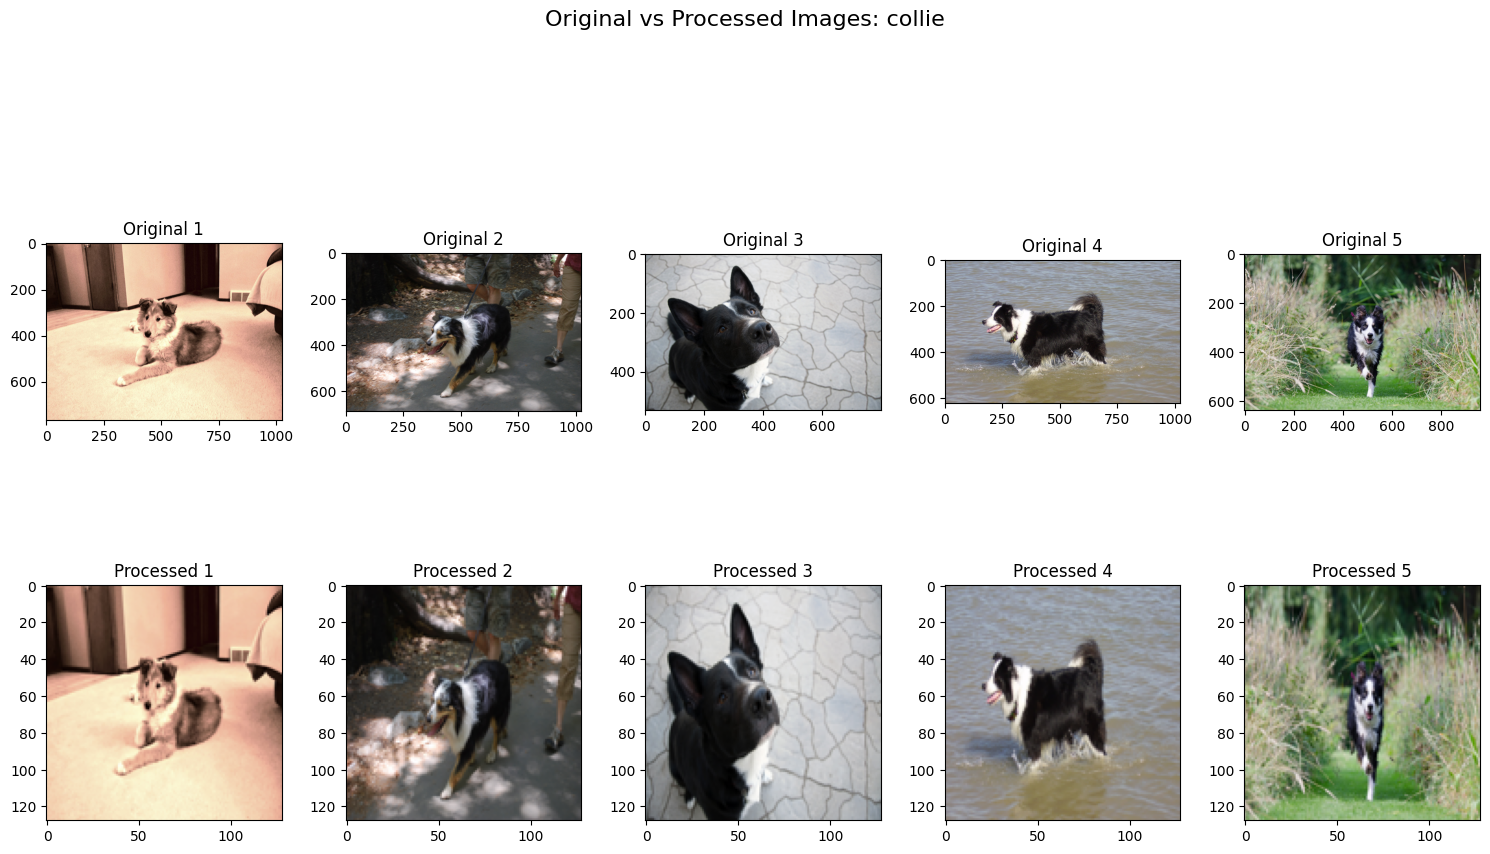

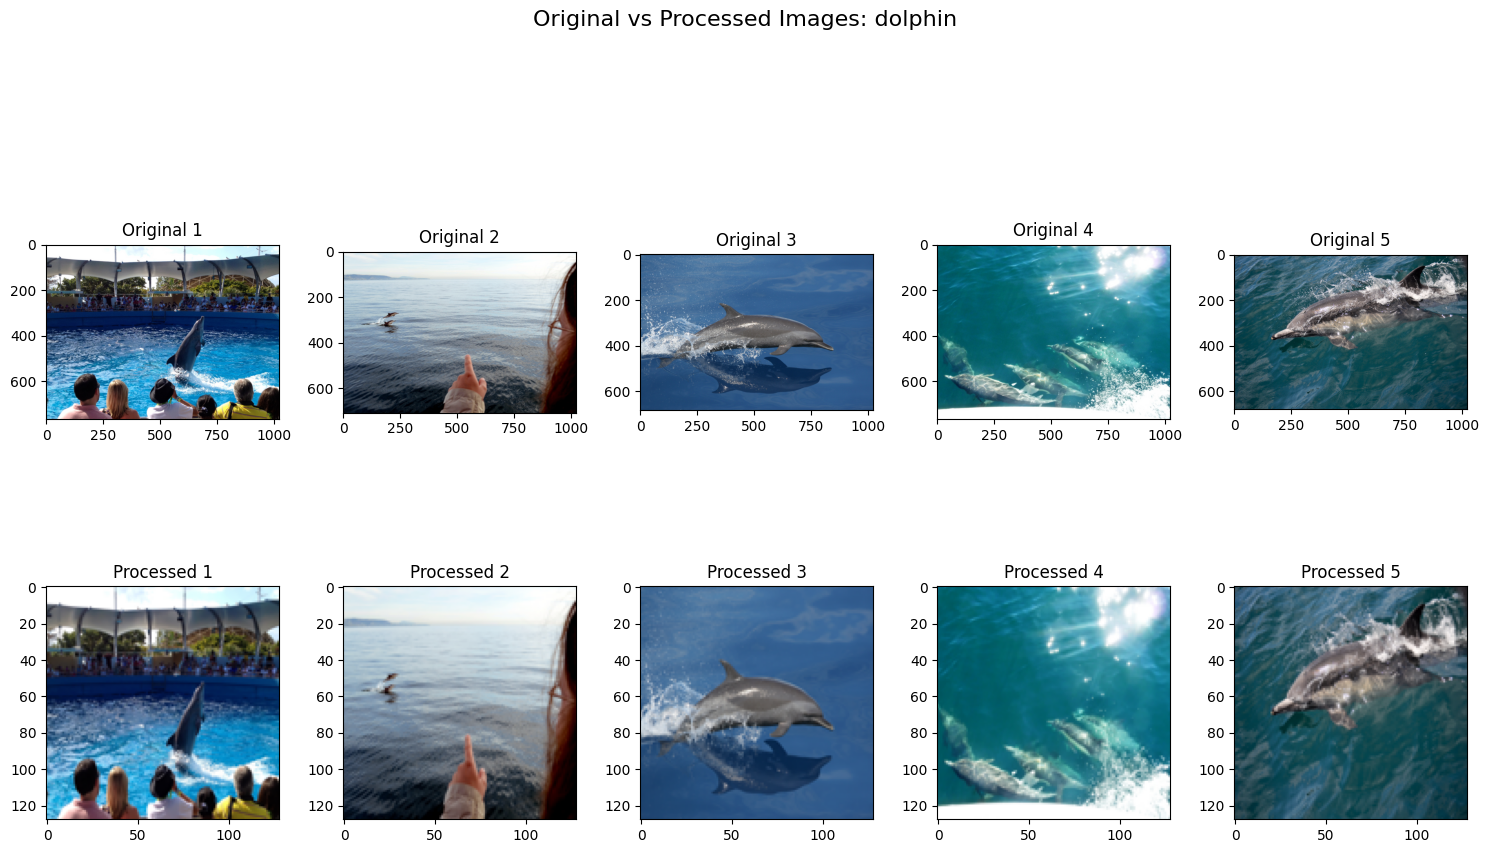

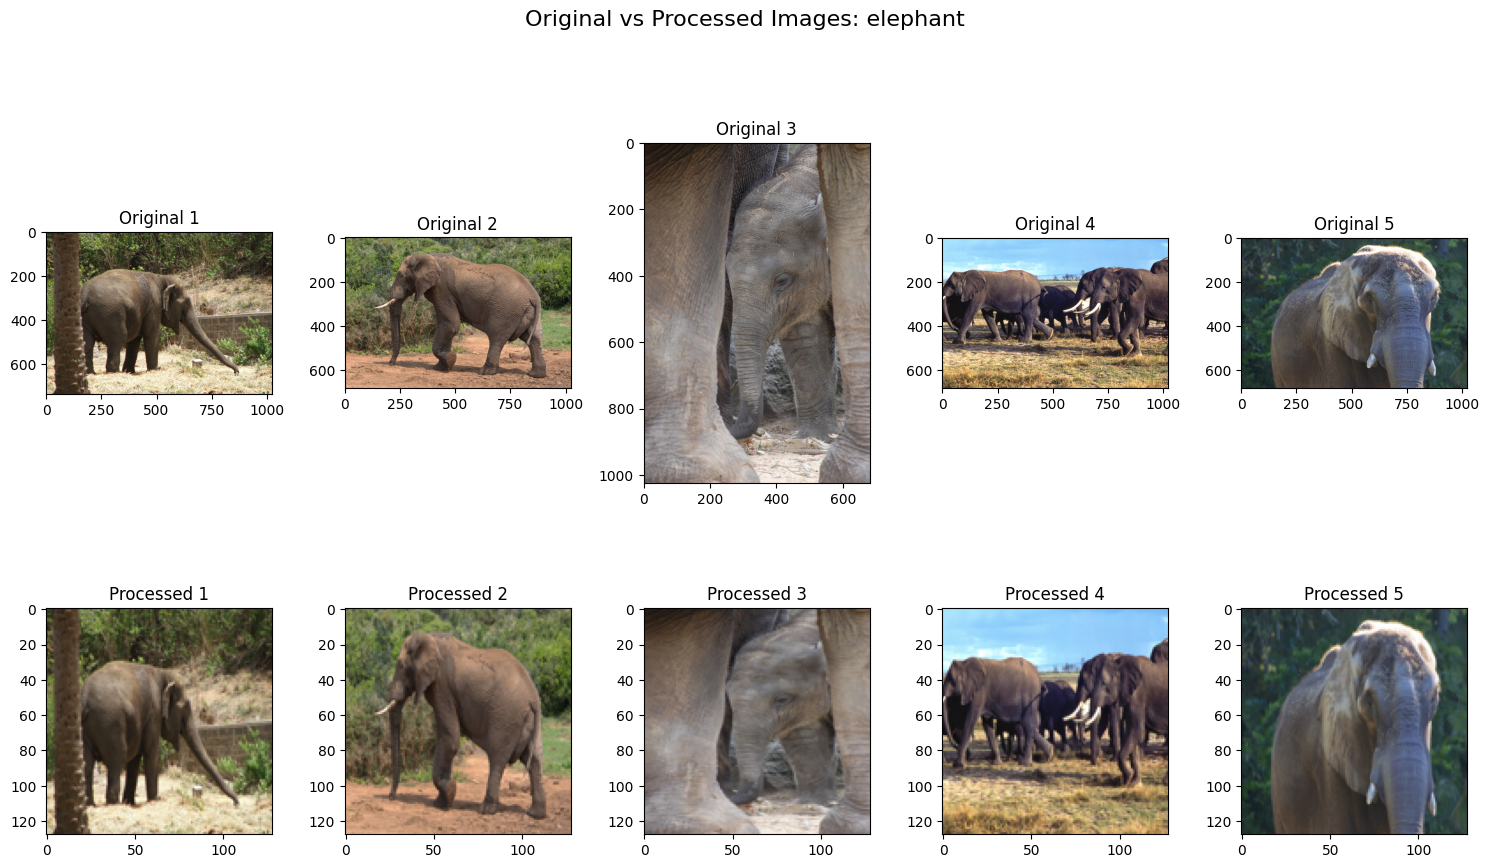

In [7]:
# Showing the preprocessed images
def display_images(class_name, class_path, num_images=5):
    original_images = []
    processed_images = []
    filenames = os.listdir(class_path)[:num_images]
    for filename in filenames:
        image_path = os.path.join(class_path, filename)

        original_image = Image.open(image_path)
        original_images.append(original_image)

        processed_image = preprocess_image(image_path, image_size)
        processed_images.append(processed_image)

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 10))
    fig.suptitle(f"Original vs Processed Images: {class_name}", fontsize=16)

    for i, img in enumerate(original_images):
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('on')

    for i, img in enumerate(processed_images):
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Processed {i+1}")
        axes[1, i].axis('on')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


for animal in target_classes[:3]:  # Adjust range to display for other classes
    class_path = os.path.join(output_path, animal)
    display_images(animal, class_path)

##### STEP 3: Splitting the dataset

Before training the model, I divided the dataset into two parts:
- **Training Set** 80%
- **Test Set** 20%

This split ensures that the model is trained on a subset of data, and the test set remains unseen to provide an unbiased evaluation of the model's performance.


In [8]:
# Collecting images nad labels
X, y = [], []
for class_name in target_classes:
    class_path = os.path.join(output_path, class_name)
    for filename in os.listdir(class_path):
        X.append(preprocess_image(os.path.join(class_path, filename), image_size))
        y.append(class_name)

# Converting to numpy arrays
X = np.array(X)
y = np.array(y)

# Converting labels to numeric
label_to_index = {label: idx for idx, label in enumerate(target_classes)}
y_numeric = np.array([label_to_index[label] for label in y])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# One-hot encoding labels
y_train_encoded = to_categorical(y_train, num_classes=len(target_classes))
y_test_encoded = to_categorical(y_test, num_classes=len(target_classes))


In [9]:
# Checking the sizes of the splits
print(f"Training data: {X_train.shape[0]} images")
print(f"Testing data: {X_test.shape[0]} images")
print(f"Training labels: {y_train_encoded.shape[0]}")
print(f"Testing labels: {y_test_encoded.shape[0]}")


Training data: 5200 images
Testing data: 1300 images
Training labels: 5200
Testing labels: 1300


##### STEP 4: Data Augmentation

Data augmentation is a technique used to increase the size of the training dataset by applying random transformations to the images.

1. **Rotation**: Random rotation of images up to 30 degrees.
2. **Width and Height Shifts**: Random shifts in the width and height of images by up to 20% of their respective dimensions.
3. **Zoom**: Random zooming of images by up to 30%.
4. **Horizontal Flip**: Random horizontal flipping of images.
5. **Vertical Flip**: No vertical flipping is applied in this case, as it may not be relevant for certain types of objects. (such as animals)
6. **Fill Mode**: New pixels that appear after the transformations are filled using the nearest pixel value, ensuring no empty areas in the augmented images.



In [10]:
datagen = ImageDataGenerator(
    rotation_range=30,         # Rotation up to 30 degrees
    width_shift_range=0.2,     # Horizontal shift up to 20% of the image width
    height_shift_range=0.2,    # Vertical shift up to 20% of the image height
    zoom_range=0.3,            # Zoom up to 30%
    horizontal_flip=True,      # Horizontal flipping
    vertical_flip=False,       # No vertical flipping
    fill_mode='nearest',       # Nearest fill for new pixels
)
datagen.fit(X_train)


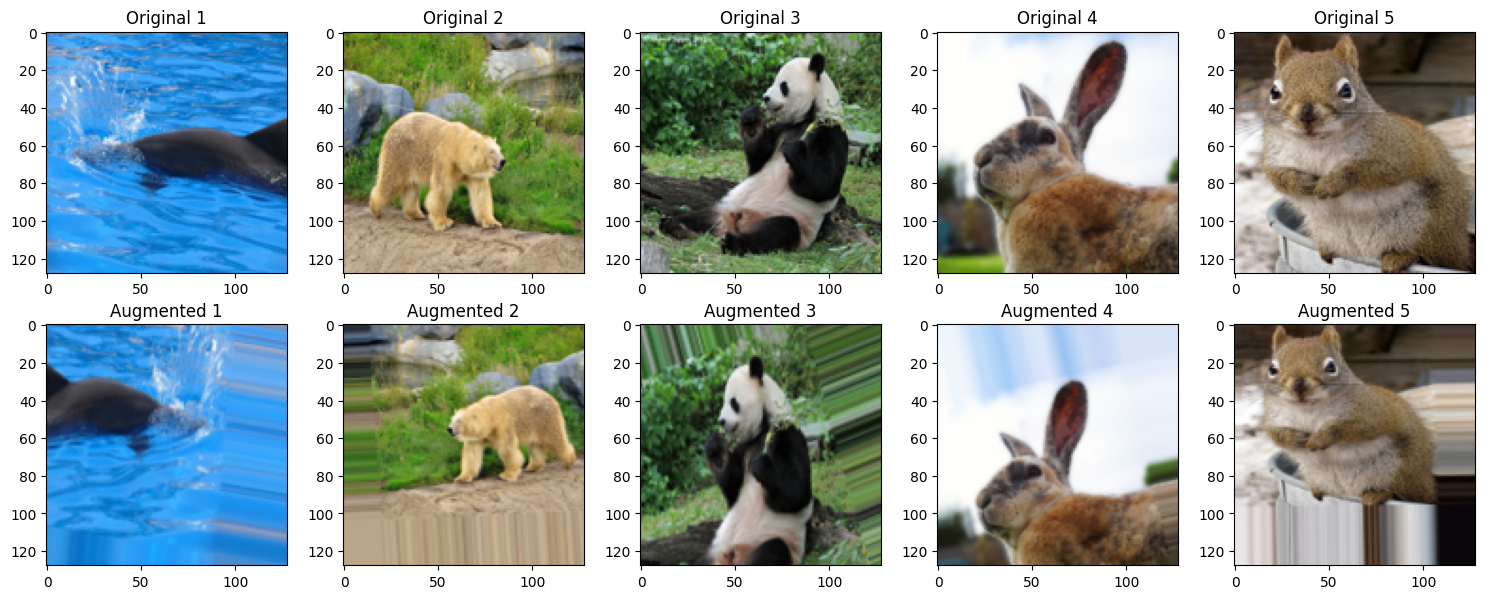

In [11]:
# Function to display original and augmented images
def show_augmented_images(X_train, datagen, num_images=5):
    sample_images = X_train[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))

    for i, img in enumerate(sample_images):
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Original {i+1}")

        augmented_img = datagen.random_transform(img)
        axes[1, i].imshow(augmented_img)
        axes[1, i].set_title(f"Augmented {i+1}")

    plt.tight_layout()
    plt.show()

show_augmented_images(X_train, datagen)


### 3-) Designing the CNN Model

A Convolutional Neural Network (CNN) is designed to classify the images.

1. **Convolutional Layers**: These layers apply convolution operations to extract features from the images. Each layer learns different filters (kernels) that help detect patterns like edges, textures, or shapes.
2. **Activation Functions (ReLU)**: These introduce non-linearity to the model, allowing it to learn complex patterns.
3. **Pooling Layers**: These layers downsample the image dimensions to reduce computational cost and control overfitting.
4. **Fully Connected (Dense) Layers**: These layers connect all neurons and classify the features extracted by the convolutional layers.


In [12]:
# Building the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Normalize activations

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Flatten the output to feed into the fully connected layers
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer to reduce overfitting

    # Output layer for classification (10 classes)
    Dense(len(target_classes), activation='softmax')  # Softmax for multi-class classification
])

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Model summary to view architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,826 (12.61 MB)

 Trainable params: 3,306,378 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

### 4-) Testing the Model

Once the model is trained, I tested it on the original test set, as well as the manipulated and color-corrected sets.(later)
- **Accuracy**: The percentage of correctly classified images out of the total number of images.
- **Precision**: The proportion of positive predictions that were actually correct.
- **Recall**: The proportion of actual positives that were correctly identified.
- **F1-Score**: The harmonic mean of precision and recall, providing a balanced metric.

I also visualize the confusion matrix.


In [13]:
history = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    validation_data=(X_test, y_test_encoded),
    epochs=20,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=2
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 - 275s - 2s/step - accuracy: 0.2244 - loss: 6.3575 - val_accuracy: 0.1238 - val_loss: 6.0799 - learning_rate: 0.0010
Epoch 2/20
163/163 - 260s - 2s/step - accuracy: 0.2190 - loss: 2.7764 - val_accuracy: 0.2223 - val_loss: 3.2962 - learning_rate: 0.0010
Epoch 3/20
163/163 - 229s - 1s/step - accuracy: 0.2631 - loss: 2.1587 - val_accuracy: 0.2685 - val_loss: 2.0287 - learning_rate: 0.0010
Epoch 4/20
163/163 - 263s - 2s/step - accuracy: 0.2863 - loss: 2.0678 - val_accuracy: 0.4108 - val_loss: 1.7796 - learning_rate: 0.0010
Epoch 5/20
163/163 - 271s - 2s/step - accuracy: 0.2994 - loss: 2.0044 - val_accuracy: 0.4031 - val_loss: 1.7354 - learning_rate: 0.0010
Epoch 6/20
163/163 - 235s - 1s/step - accuracy: 0.2892 - loss: 2.0344 - val_accuracy: 0.3846 - val_loss: 1.8216 - learning_rate: 0.0010
Epoch 7/20
163/163 - 262s - 2s/step - accuracy: 0.3110 - loss: 1.9599 - val_accuracy: 0.4100 - val_loss: 1.7503 - learning_rate: 0.0010
Epoch 8/20
163/163 - 227s - 1s/step - accuracy: 0.3252 - lo

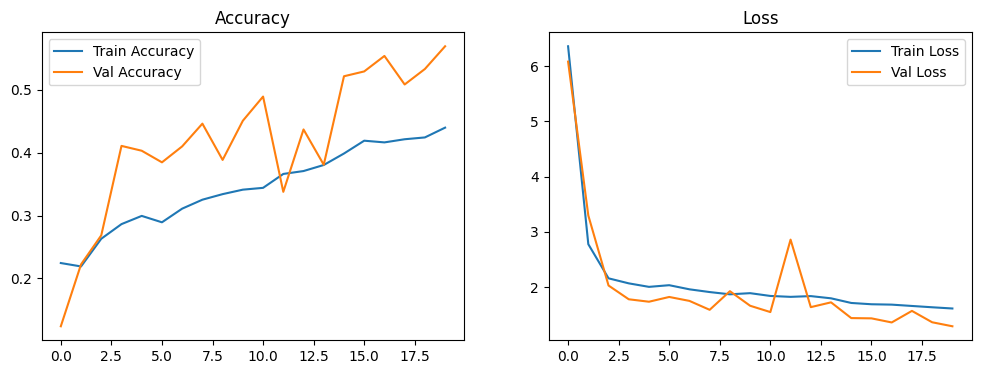

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step


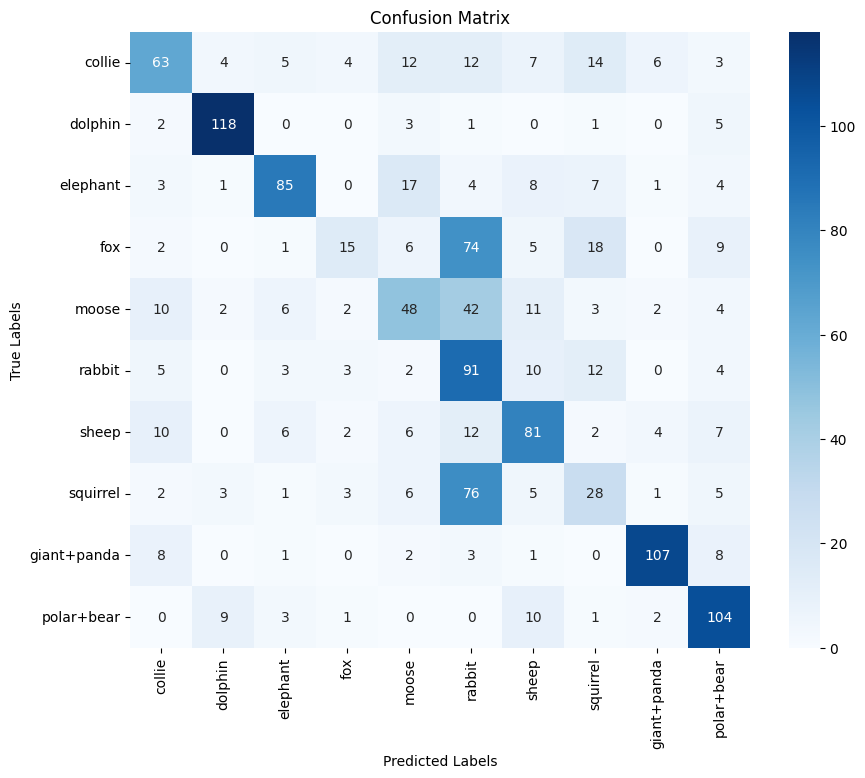


Classification Report:

              precision    recall  f1-score   support

      collie       0.60      0.48      0.54       130
     dolphin       0.86      0.91      0.88       130
    elephant       0.77      0.65      0.71       130
         fox       0.50      0.12      0.19       130
       moose       0.47      0.37      0.41       130
      rabbit       0.29      0.70      0.41       130
       sheep       0.59      0.62      0.60       130
    squirrel       0.33      0.22      0.26       130
 giant+panda       0.87      0.82      0.85       130
  polar+bear       0.68      0.80      0.73       130

    accuracy                           0.57      1300
   macro avg       0.59      0.57      0.56      1300
weighted avg       0.59      0.57      0.56      1300



In [14]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=target_classes))



By comparing performance on the original, manipulated, and color-corrected test sets, we can see how the image preprocessing and augmentation techniques impact the model’s classification accuracy.

### 5-6-) Manipulating Images with Different Lightning and Testing

1. **Brightness and Contrast Adjustment**

2. **Edge Detection and Histogram Equalization**

3. **Manipulating a Set of Images**

4. **Display of Original vs. Manipulated Images**

In [15]:
def manipulate_images(images, brightness=200, contrast=10.0):
    manipulated_images = []
    for img in images:
        img = cv2.convertScaleAbs(img, alpha=contrast, beta=brightness)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, threshold1=50, threshold2=150)
        equalized_img = cv2.equalizeHist(gray)
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        combined = cv2.addWeighted(img, 0.7, edges_colored, 0.3, 0)
        manipulated_images.append(cv2.cvtColor(combined, cv2.COLOR_BGR2GRAY))
    return np.array(manipulated_images)

manipulated_X_test = manipulate_images(X_test)


In [16]:
def display_original_vs_manipulated(X_test, manipulated_images, num_images=5):
    original_images = X_test[:num_images]
    manipulated_images_sample = manipulated_images[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    fig.suptitle(f"Original vs Manipulated Images", fontsize=16)

    for i, img in enumerate(original_images):
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

    for i, img in enumerate(manipulated_images_sample):
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Manipulated {i+1}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


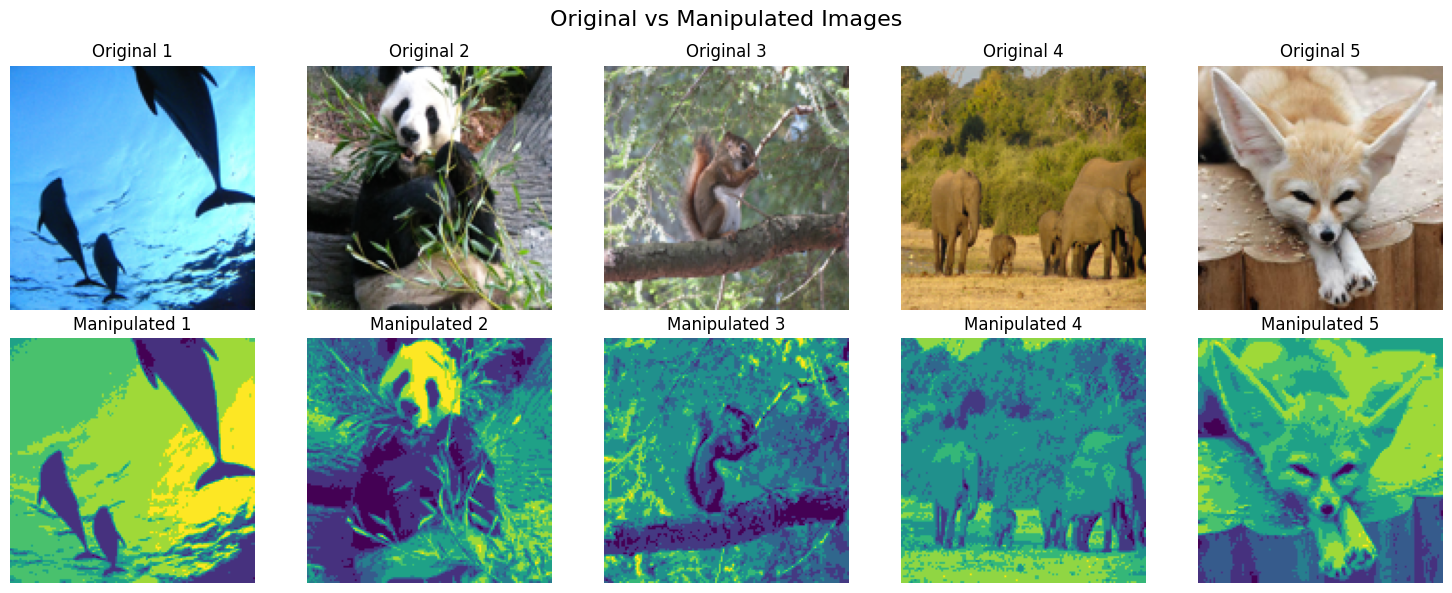

In [17]:
display_original_vs_manipulated(X_test, manipulated_X_test)


In [18]:
predictions = model.predict(manipulated_X_test)

predicted_labels = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report on Manipulated Test Set:\n")
print(classification_report(y_test, predicted_labels, target_names=target_classes))

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(32, 128, 128), dtype=float32). Expected shape (None, 128, 128, 3), but input has incompatible shape (32, 128, 128)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 128, 128), dtype=uint8)
  • training=False
  • mask=None

### 7-8-) Adding Color Constancy Algortihm and Testing

In [ ]:
def get_wb_images(image):
    img_float = image.astype(np.float32)

    mean_b, mean_g, mean_r = np.mean(img_float[:, :, 0]), np.mean(img_float[:, :, 1]), np.mean(img_float[:, :, 2])

    avg_mean = (mean_b + mean_g + mean_r) / 3

    img_float[:, :, 0] *= avg_mean / mean_b
    img_float[:, :, 1] *= avg_mean / mean_g
    img_float[:, :, 2] *= avg_mean / mean_r

    img_corrected = np.clip(img_float, 0, 255).astype(np.uint8)

    return img_corrected


In [ ]:
def apply_color_constancy(images):
    return np.array([get_wb_images(img) for img in images])

color_corrected_X_test = apply_color_constancy(manipulated_X_test)

predictions_corrected = model.predict(color_corrected_X_test)

predicted_labels_corrected = np.argmax(predictions_corrected, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report on Color-Corrected Test Set:\n")
print(classification_report(y_test, predicted_labels_corrected, target_names=target_classes))

import matplotlib.pyplot as plt


In [ ]:
predictions_corrected = model.predict(color_corrected_X_test)

predicted_labels_corrected = np.argmax(predictions_corrected, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report on Color-Corrected Test Set:\n")
print(classification_report(y_test, predicted_labels_corrected, target_names=target_classes))


In [ ]:
def display_images(original, manipulated, corrected, num_images=5):
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 3, 9))
    fig.suptitle(f"Original vs Manipulated vs Color-Corrected Images", fontsize=16)

    for i in range(num_images):
        axes[0, i].imshow(original[i])
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        axes[1, i].imshow(manipulated[i])
        axes[1, i].set_title(f"Manipulated {i+1}")
        axes[1, i].axis('off')

        axes[2, i].imshow(corrected[i])
        axes[2, i].set_title(f"Corrected {i+1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(X_test, manipulated_X_test, color_corrected_X_test)


### 9-) Comparing

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step

Classification Report on Original Test Set:

              precision    recall  f1-score   support

      collie       0.60      0.48      0.54       130
     dolphin       0.86      0.91      0.88       130
    elephant       0.77      0.65      0.71       130
         fox       0.50      0.12      0.19       130
       moose       0.47      0.37      0.41       130
      rabbit       0.29      0.70      0.41       130
       sheep       0.59      0.62      0.60       130
    squirrel       0.33      0.22      0.26       130
 giant+panda       0.87      0.82      0.85       130
  polar+bear       0.68      0.80      0.73       130

    accuracy                           0.57      1300
   macro avg       0.59      0.57      0.56      1300
weighted avg       0.59      0.57      0.56      1300

Accuracy on Original Test Set: 56.92%


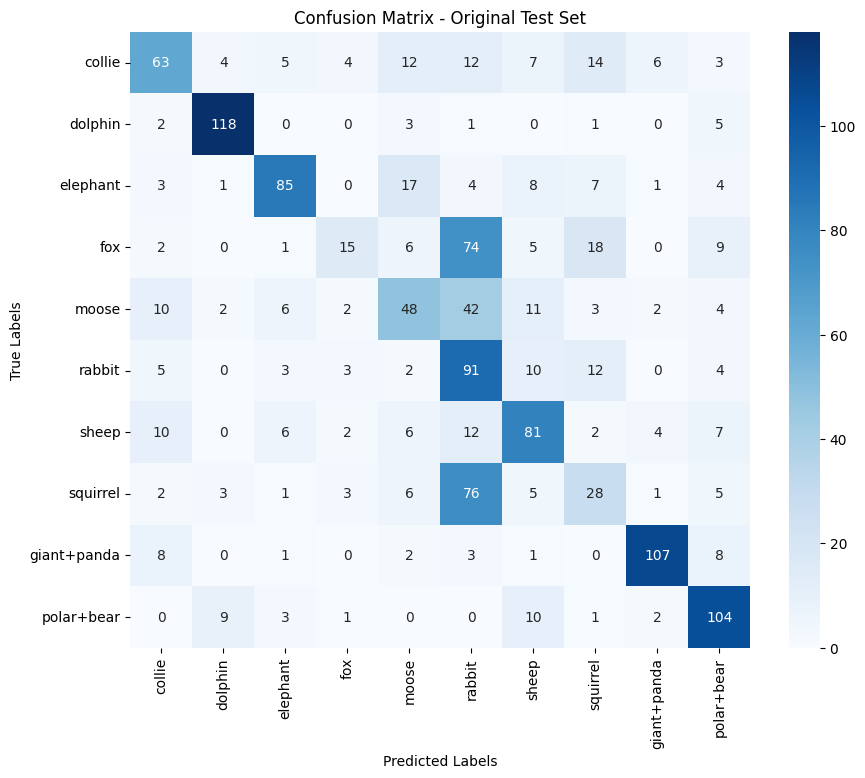

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(32, 128, 128), dtype=float32). Expected shape (None, 128, 128, 3), but input has incompatible shape (32, 128, 128)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 128, 128), dtype=uint8)
  • training=False
  • mask=None

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Evaluate on the original test set
y_pred_original = np.argmax(model.predict(X_test), axis=1)
accuracy_original = accuracy_score(y_test, y_pred_original)
print("\nClassification Report on Original Test Set:\n")
print(classification_report(y_test, y_pred_original, target_names=target_classes))
print(f"Accuracy on Original Test Set: {accuracy_original * 100:.2f}%")

# Confusion Matrix for Original Test Set
cm_original = confusion_matrix(y_test, y_pred_original)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_original, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap='Blues')
plt.title('Confusion Matrix - Original Test Set')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Evaluate on the manipulated test set
y_pred_manipulated = np.argmax(model.predict(manipulated_X_test), axis=1)
accuracy_manipulated = accuracy_score(y_test, y_pred_manipulated)
print("\nClassification Report on Manipulated Test Set:\n")
print(classification_report(y_test, y_pred_manipulated, target_names=target_classes))
print(f"Accuracy on Manipulated Test Set: {accuracy_manipulated * 100:.2f}%")

# Confusion Matrix for Manipulated Test Set
cm_manipulated = confusion_matrix(y_test, y_pred_manipulated)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_manipulated, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap='Blues')
plt.title('Confusion Matrix - Manipulated Test Set')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Evaluate on the color-corrected test set
y_pred_corrected = np.argmax(model.predict(color_corrected_X_test), axis=1)
accuracy_corrected = accuracy_score(y_test, y_pred_corrected)
print("\nClassification Report on Color-Corrected Test Set:\n")
print(classification_report(y_test, y_pred_corrected, target_names=target_classes))
print(f"Accuracy on Color-Corrected Test Set: {accuracy_corrected * 100:.2f}%")

# Confusion Matrix for Color-Corrected Test Set
cm_corrected = confusion_matrix(y_test, y_pred_corrected)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_corrected, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap='Blues')
plt.title('Confusion Matrix - Color-Corrected Test Set')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Comparing the accuracies
print(f"\nAccuracy Comparison:")
print(f"Original Test Set: {accuracy_original * 100:.2f}%")
print(f"Manipulated Test Set: {accuracy_manipulated * 100:.2f}%")
print(f"Color-Corrected Test Set: {accuracy_corrected * 100:.2f}%")
